In [9]:
%matplotlib inline

from __future__ import division

import numpy as np
import matplotlib.pyplot as pl
from scipy.integrate import odeint

Let's use a planar coordinate system (everything has z = 0), so we just have two coordinates (x,y). If we have a position array x, then let's say that x[0] = x, x[1] = y.

### Some constants

We're operating in units of (parsecs), (solar masses) and (km/s)

In [10]:
G_N = 4.302e-3 #(pc/solar mass) (km/s)^2
M_PBH = 30.0
r_tr = 0.0063*(M_PBH**(1.0/3.0))

A = 3*M_PBH/(8*np.pi*r_tr**3)

### Some random functions

Mass enclosed in the halo at a given distance:

In [11]:
#Mass of PBH + DM within a radius r
def Menc(r):
    if (r > r_tr):
        return 2.0*M_PBH
    else:
        return M_PBH*(1+(r/r_tr)**(3/2))

In [12]:
def density(r):
    if (r > r_tr):
        return 0
    else:
        return A*(r/r_tr)**(-3.0/2.0)

Gravitational force

In [75]:
def F_grav(x,v):
    r = np.sqrt(x[0]**2 + x[1]**2)
    return -x*G_N*Menc(r)*M_PBH/r**3

Dynamical friction force (this is just a place holder for now, need to set it up correctly with correct constants etc...)

In [76]:
def F_dyn(x,v):
    r = np.sqrt(x[0]**2 + x[1]**2)
    v_abs = np.sqrt(v[0]**2 + v[1]**2)
    A = 0 #THIS CONSTANT MEANS THAT WE'RE IGNORING DYNAMICAL FRICTION
    return -A*v*density(r)/v_abs**3

### Set up the system and solve the ODE:

In [164]:
#Initial x , y
x_init = [0, 2*r_tr]

#Initial v_x, v_y (let's pick some random values for now, rather than setting up things correctly)
v_init = [2.0, 0]

#Try this one to get a nice eccentric orbit (which doesn't pass through the halo, so it behaves nicely)
#v_init = [2.2, 0]

s_init = np.append(x_init, v_init)

In [165]:
#Derivative. Here s is the combined phase space coordinates: s[0] = x, s[1] = y, s[2] = v_x, s[3] = v_y
def dsdt(s, t):
    ds = s*0.0
    #Derivative of the position is the speed...Easy!
    ds[0] = s[2]
    ds[1] = s[3]
    
    x = s[0:2]
    v = s[2:4]
    
    #Calculate acceleration:
    force = F_grav(x,v) + F_dyn(x,v)
    ds[2] = force[0]/M_PBH
    ds[3] = force[1]/M_PBH
    
    return ds
    

In [170]:
tvals = np.linspace(0, 1,1000)

ode_result = odeint(dsdt, s_init, tvals)

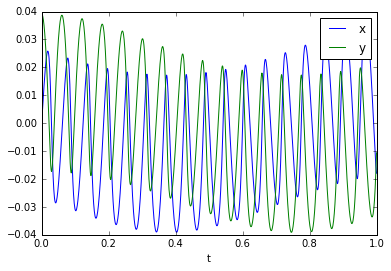

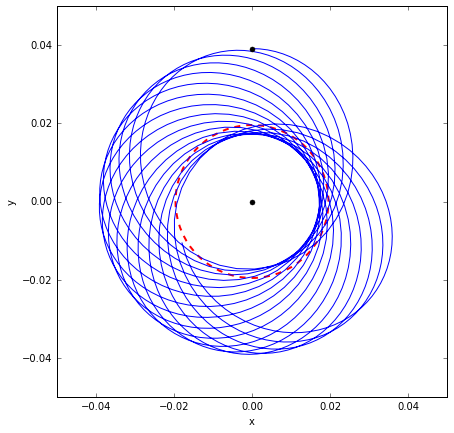

In [172]:
#plot x and y as a function of t
pl.figure()
pl.plot(tvals, ode_result[:,0], label="x")
pl.plot(tvals, ode_result[:,1], label="y")
pl.xlabel("t")
pl.legend()

#Trace the orbit
f = pl.figure(figsize=(7,7))
pl.plot(ode_result[:,0], ode_result[:,1])

pl.plot([0.0,0.0], 'ko',ms=5.0)
pl.plot(x_init[0], x_init[1], 'ko',ms=5.0)

circle1 = pl.Circle((0, 0), r_tr, color='r', linestyle='--',linewidth=2.0, fill=False)
ax = f.gca()
ax.add_artist(circle1)
pl.xlabel("x")
pl.ylabel("y")
pl.xlim(-0.05, 0.05)
pl.ylim(-0.05, 0.05)

pl.show()